In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [32]:
chrom = "22"
model = "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True"
min_count_per_consequence = 30

variants = f"../../results/positions/{chrom}/llr/{model}.subsample_10000000.annot.parquet"
#variants = f"../../results/positions/{chrom}/llr/{model}.conserved_pos_full_22.annot.parquet"

V = pl.read_parquet(variants)
V = V.with_columns(
    pl.col("consequence").str.replace("_variant", "")
)

# optional: replace with model without flipping
V = V.with_columns(
    score=pl.read_parquet("../../results/preds/results/ism_subset/multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/False.parquet")["score"]
)

V

chrom,pos,ref,alt,score,consequence
str,i64,str,str,f32,str
"""22""",10510068,"""A""","""G""",-2.857422,"""intergenic"""
"""22""",10510076,"""T""","""G""",-4.382812,"""intergenic"""
"""22""",10510080,"""A""","""T""",-4.503906,"""intergenic"""
"""22""",10510084,"""T""","""C""",1.0390625,"""intergenic"""
"""22""",10510087,"""T""","""G""",-1.240234,"""intergenic"""
"""22""",10510093,"""C""","""T""",-0.216919,"""intergenic"""
"""22""",10510098,"""T""","""C""",-4.558594,"""intergenic"""
"""22""",10510100,"""C""","""A""",-3.8125,"""intergenic"""
"""22""",10510100,"""C""","""G""",-3.941406,"""intergenic"""


In [33]:
c_counts = V["consequence"].value_counts().sort("count", descending=True)
c_counts

consequence,count
str,u32
"""intron""",5275697
"""intergenic""",3446002
"""non_coding_tra…",443413
"""3_prime_UTR""",198938
"""upstream_gene""",183453
"""downstream_gen…",170413
"""missense""",140041
"""5_prime_UTR""",46155
"""synonymous""",42172


In [34]:
c_quantile = V.filter(
    pl.col("consequence").is_in(c_counts.filter(pl.col("count") >= min_count_per_consequence)["consequence"])
).group_by("consequence").agg(pl.quantile("score", 0.01)).sort("score")
c_quantile

consequence,score
str,f32
"""splice_accepto…",-13.203125
"""stop_gained""",-13.125
"""splice_donor""",-13.109375
"""splice_donor_5…",-12.921875
"""missense""",-12.679688
"""start_lost""",-12.460938
"""stop_lost""",-12.460938
"""splice_donor_r…",-11.03125
"""mature_miRNA""",-10.515625


In [35]:
c_plot = c_quantile["consequence"]
c_plot

consequence
str
"""splice_accepto…"
"""stop_gained"""
"""splice_donor"""
"""splice_donor_5…"
"""missense"""
"""start_lost"""
"""stop_lost"""
"""splice_donor_r…"
"""mature_miRNA"""


In [36]:
# Optional filtering
#c_plot = ["missense", "synonymous"]
c_plot = [
    "stop_gained",
    "missense",
    "5_prime_UTR",
    "3_prime_UTR",
    "synonymous",
    "intergenic",
]

In [37]:
score_col = "GPN-MSA score"
df = V.filter(pl.col("consequence").is_in(c_plot)).to_pandas()
df["g"] = df.consequence
df[score_col] = df.score
df['consequence'] = pd.Categorical(df['consequence'], categories=c_plot, ordered=True)
df = df.sort_values("consequence")
df

,chrom,pos,ref,alt,score,consequence,g,GPN-MSA score
3068297,22,41346043,C,A,-10.171875,stop_gained,stop_gained,-10.171875
1955400,22,26599582,G,A,-9.734375,stop_gained,stop_gained,-9.734375
2656405,22,36254994,C,A,-3.142578,stop_gained,stop_gained,-3.142578
2317573,22,31715138,C,A,-4.789062,stop_gained,stop_gained,-4.789062
1955387,22,26599543,G,A,-9.679688,stop_gained,stop_gained,-9.679688
...,...,...,...,...,...,...,...,...
1268102,22,18039524,A,C,-5.437500,intergenic,intergenic,-5.437500
1268103,22,18039532,G,C,-1.702148,intergenic,intergenic,-1.702148
1268104,22,18039533,A,G,-2.769531,intergenic,intergenic,-2.769531
1268106,22,18039546,T,A,-4.929688,intergenic,intergenic,-4.929688


In [38]:
q = 1 / 10_000 #1/2_000
x_left, x_right = df[score_col].quantile(q), df[score_col].quantile(1-q)
x_left, x_right

(-13.1015625, 5.77734375)

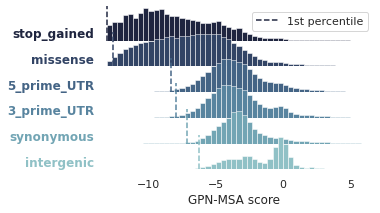

In [40]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

pal = sns.cubehelix_palette(len(c_plot), rot=-.25, light=.7, reverse=True)
g = sns.FacetGrid(
    df, row="g", hue="g",
    aspect=10,#15,
    #height=.5,  # doesn't work
    #height=1, # this works
    height=0.5,
    palette=pal,
    sharey=False,
)

g.map(
    sns.histplot,
    score_col,
    bins=np.linspace(x_left, x_right, 50),
    alpha=1,
    fill=True,
    stat="density",
)

def label(x, color, label):
    ax = plt.gca()
    ax.text(
        0, .2, label, fontweight="bold", color=color,
        ha="right",
        va="center", transform=ax.transAxes
    )
g.map(label, score_col)

def add_quantile(x, color, label):
    ax = plt.gca()
    artist = ax.axvline(x.quantile(0.01), ls='--', color=color)
    
g.map(add_quantile, score_col)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True);
import matplotlib

artist = [c for c in g.axes[0,0].get_children() if type(c)==matplotlib.lines.Line2D][0]
legend = g.axes[0,0].legend([artist], ["1st percentile"], loc="upper right")
legend.get_frame().set_facecolor('white')

#plt.axvline(-1.6)

#plt.savefig("../../results/plots/ism.pdf", bbox_inches="tight")
#plt.savefig("../../results/plots/ism_fully_conserved_pos.pdf", bbox_inches="tight")

In [24]:
0.5 * 0.75 / 3

0.125

In [ ]:
0.625, 0.125, 0.125, 0.125